# Example: Seismic Data Evaluation

Set the backend of matplotlib to the 'inline' backend (specific for Jupyter notebooks) so that result of all plotting commands is displayed inline directly below the code cell that produces it.

In [1]:
 %matplotlib inline

#### Import the standard and third party Python libraries.

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, os.sep.join(['..', '..', 'source']))
from openiam import SystemModel
sys.path.insert(0, os.sep.join(['..', '..', 'ramp']))
from ramp.data_container import default_bin_file_reader, process_time_points, get_indices
from ramp.monitoring_technology import MonitoringTechnology
from ramp.seismic_data_container import SeismicDataContainer
from ramp.seismic_configuration import SeismicSurveyConfiguration
from ramp.seismic_monitoring import SeismicMonitoring
from ramp.seismic_evaluation import SeismicEvaluation

#### Setup arguments of system model.

In [3]:
# Define keyword arguments of the system model
final_year = 90
num_intervals = (final_year-10)//10
time_array = 365.25*np.linspace(10.0, final_year, num=num_intervals+1)
sm_model_kwargs = {'time_array': time_array}   # time is given in days

#### Setup arguments of seismic data container.

In [4]:
# Observation name
obs_name = 'seismic'

# Path to the data files
data_directory = os.path.join('..', '..', 'data', 'user', 'seismic')
output_directory = os.path.join('..', '..', 'examples', 'user', 'output',
                                'ramp_sys_seismic_evaluation')
if not os.path.exists(output_directory):
    os.mkdir(output_directory)

# Data reader to be used to read data files
data_reader = default_bin_file_reader
# Keyword arguments for reader specifying expected data shape and reformatting needed
data_reader_kwargs = {'data_shape': (1251, 101, 9),
                      'move_axis_destination': [-1, -2, -3]}

# Time points at which data is available, in years
time_points = np.linspace(10.0, final_year, num=num_intervals+1)
num_time_points = len(time_points)

# Select scenarios to link to the data container
scenarios = list(range(1, 6))
num_scenarios = len(scenarios)

# Data family
family = 'seismic'

# Setup dictionary needed for data container setup
data_setup = {}
for ind in scenarios:
    data_setup[ind] = {'folder': os.path.join('data_sim{:04}'.format(ind), 'data')}
    for t_ind in range(1, num_time_points+1):
        data_setup[ind]['t{}'.format(t_ind)] = 'data_sim{:04}_t{}.bin'.format(ind, t_ind*10)

# baseline is True if data is supposed to have baseline data
baseline = True

#### Print summary of available data.

In [5]:
print('Type of data:', family)
print('Number of available scenarios:', num_scenarios)
print('Years at which data is analyzed:', time_points)
print('Expected data shape:', (9, 101, 1251), '= (n_s x n_r x n_t)')
print('n_s: number of sources')
print('n_r: number of receivers')
print('nt: number of time samples for each trace')

Type of data: seismic
Number of available scenarios: 5
Years at which data is analyzed: [10. 20. 30. 40. 50. 60. 70. 80. 90.]
Expected data shape: (9, 101, 1251) = (n_s x n_r x n_t)
n_s: number of sources
n_r: number of receivers
nt: number of time samples for each trace


#### Setup arguments of seismic survey configuration for all available sources and receivers.

In [6]:
# Define coordinates of sources
num_sources = 9
sources = np.c_[4000 + np.array([240, 680, 1120, 1600, 2040, 2480, 2920, 3400, 3840]),
                np.zeros(num_sources),
                np.zeros(num_sources)]

# Define coordinates of receivers
num_receivers = 101
receivers = np.c_[4000 + np.linspace(0, 4000, num=num_receivers),
                  np.zeros(num_receivers),
                  np.zeros(num_receivers)]

# Create survey with defined coordinates
survey_config = SeismicSurveyConfiguration(sources, receivers, name='Seismic Survey')

#### Plot seismic survey configuration.

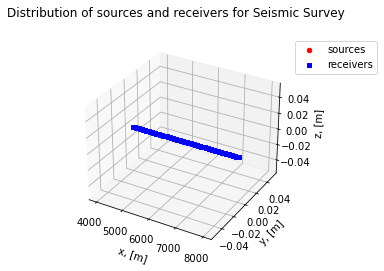

In [7]:
survey_config.plot_configuration()

#### Create System Model.

In [8]:
# Create system model
sm = SystemModel(model_kwargs=sm_model_kwargs)

#### Create and setup Seismic Data Container.
Seismic Data Container reads data from linked data files and output produced data for other components to use.

In [9]:
# Add data container
dc = sm.add_component_model_object(
    SeismicDataContainer(name='dc', parent=sm, survey_config=survey_config,
                         total_duration=2.5,
                         sampling_interval=0.002,
                         family=family, obs_name=obs_name,
                         data_directory=data_directory, data_setup=data_setup,
                         time_points=time_points, baseline=baseline,
                         data_reader=data_reader,
                         data_reader_kwargs=data_reader_kwargs,
                         presetup=True))

# Add parameters of the container
dc.add_par('index', value=scenarios[0], vary=False)

# Add gridded observation seismic
dc.add_grid_obs(obs_name, constr_type='matrix', output_dir=output_directory)
dc.add_grid_obs('delta_{}'.format(obs_name), constr_type='matrix',
                output_dir=output_directory)

#### Create and setup Seismic Monitoring.
Seismic Monitoring component inputs seismic data from Seismic Data Container and calculates NRMS and associated metrics.

In [10]:
# Add seismic monitoring technology
smt = sm.add_component_model_object(
    SeismicMonitoring(name='smt', parent=sm, survey_config=survey_config,
                      time_points=time_points))

# Add keyword arguments linked to the seismic data container outputs
smt.add_kwarg_linked_to_obs('data', dc.linkobs['seismic'], obs_type='grid')
smt.add_kwarg_linked_to_obs('baseline', dc.linkobs['baseline_seismic'], obs_type='grid')

# Add gridded observation
smt.add_grid_obs('NRMS', constr_type='matrix', output_dir=output_directory)

# Add scalar observations
for nm in ['ave_NRMS', 'max_NRMS', 'min_NRMS']:
    smt.add_obs(nm)
    smt.add_obs_to_be_linked(nm)

#### Create and setup Seismic Evaluation component.
Seismic Evaluation component inputs an NRMS metric (in this example, average over all traces) and compares it to a predefined threshold.

In [11]:
# Add seismic evaluation component
seval = sm.add_component_model_object(
    SeismicEvaluation(name='seval', parent=sm, time_points=time_points))

# Add threshold parameter
threshold = 80.0
seval.add_par('threshold', value=threshold, vary=False)

# Add keyword arguments linked to the seismic monitoring metric
seval.add_kwarg_linked_to_obs('metric', smt.linkobs['ave_NRMS'])

# Add observations
for nm in ['leak_detected', 'detection_time']:
    seval.add_obs(nm)        # covers the whole simulation period
    seval.add_obs(nm + '_ts')  # covers how values change in time

#### Run model as deterministic.

In [12]:
sm_obs = sm.forward()

#### Print results of analysis.

In [13]:
# Print whether leak was detected and detection time if applicable
final_obs_ind = final_year//10 - 1
leak_detected = sm.obs['seval.leak_detected_{}'.format(final_obs_ind)].sim
print('Is leak detected?', bool(leak_detected))
if leak_detected:
    detection_time = sm.obs['seval.detection_time_{}'.format(final_obs_ind)].sim
    print('Leak is detected for the first time at t = {} days ({} years)'.format(
        detection_time, detection_time/365.25))

Is leak detected? True
Leak is detected for the first time at t = 14610.0 days (40.0 years)


#### Get selected data from saved files or directly from System Model.

In [14]:
# Get saved gridded observations from files
time_ind = final_year//10 - 1
delta_seismic = sm.collect_gridded_observations_as_time_series(
    dc, 'delta_seismic', output_directory, indices=[time_ind], rlzn_number=0)[0]
seismic = sm.collect_gridded_observations_as_time_series(
    dc, 'seismic', output_directory, indices=[time_ind], rlzn_number=0)[0]
nrms = sm.collect_gridded_observations_as_time_series(
    smt, 'NRMS', output_directory, indices=[time_ind], rlzn_number=0)

# Export scalar observations
metrics = {}
for nm in ['ave_NRMS', 'max_NRMS', 'min_NRMS']:
    metrics[nm] = sm.collect_observations_as_time_series(smt, nm)

evaluations = {}
for nm in ['leak_detected', 'detection_time']:
    evaluations[nm] = sm.collect_observations_as_time_series(seval, nm)
    evaluations[nm + '_ts'] = sm.collect_observations_as_time_series(seval, nm + '_ts')

#### Plot results.

##### Seismic Data Container outputs
Plot seismic data at the last time point and for source 6.

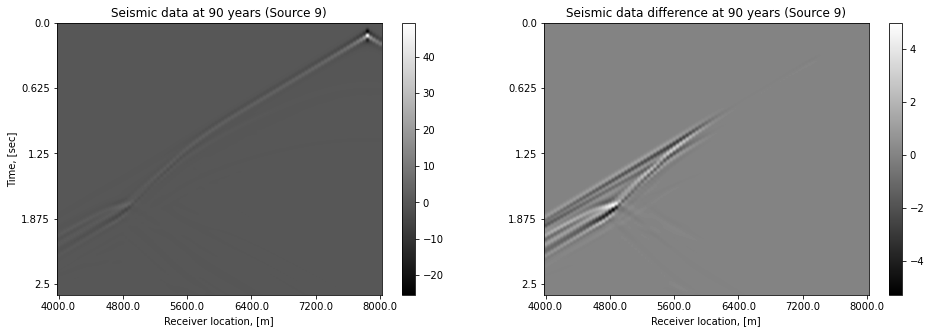

In [15]:
source_ind = 8  # Python indexing is using -1 index
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(121)
im1 = ax.imshow(seismic[source_ind, :, :].T, cmap='gray', aspect='auto')
cbar1 = fig.colorbar(im1, ax=ax, location='right')
ax.set_title('Seismic data at {} years (Source {})'.format((time_ind+1)*10, source_ind+1))
y = np.linspace(0, 1200, num=5)
ylabels = np.linspace(0, 2.5, num=5)
ax.set_yticks(y, labels=ylabels)
ax.set_ylabel('Time, [sec]')
x = np.linspace(0, 100, num=6)
xlabels = 4000+np.linspace(0, 4000, num=6)
ax.set_xticks(x, labels=xlabels)
ax.set_xlabel('Receiver location, [m]')
ax = fig.add_subplot(122)
im2 = ax.imshow(delta_seismic[source_ind, :, :].T, cmap='gray', aspect='auto')
cbar2 = fig.colorbar(im2, ax=ax, location='right')
ax.set_title('Seismic data difference at {} years (Source {})'.format((time_ind+1)*10, source_ind+1))
ax.set_xticks(x, labels=xlabels)
ax.set_xlabel('Receiver location, [m]')
yticks = ax.set_yticks(y, labels=ylabels)  # used yticks variable to avoid printing them out

##### Seismic Monitoring Component outputs
Plot NRMS at the last time point.

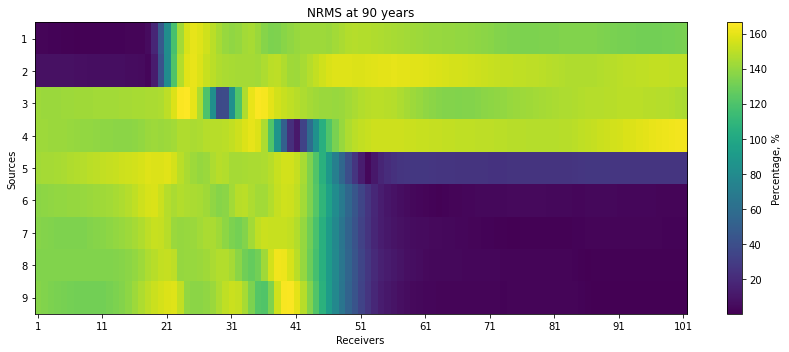

In [16]:
# Plot NRMS as image
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax_im = ax.imshow(nrms[0], aspect='auto')

# Set title
title = ax.set_title('NRMS at {} years'.format((time_ind+1)*10))

# Set x-labels
x = np.linspace(0, 100, num=11)
xlabels = np.linspace(1, 101, num=11, dtype=int)
ax.set_xticks(x, labels=xlabels)
ax.set_xlabel('Receivers')

# Set y-labels
y = np.linspace(0, 8, num=9)
ylabels = np.linspace(1, 9, num=9, dtype=int)
ax.set_yticks(y, labels=ylabels)
ax.set_ylabel('Sources')

# Add colorbar
cbar = plt.colorbar(ax_im, label='Percentage, %')
fig.tight_layout()


Plot NRMS histogram and metrics changing in time.

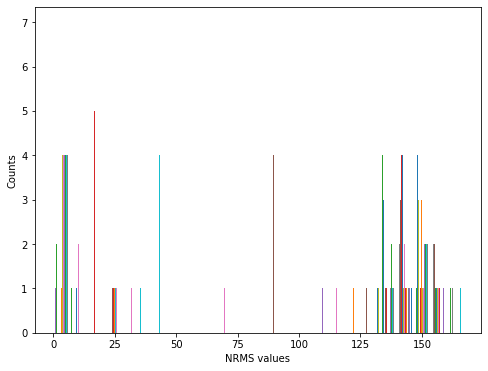

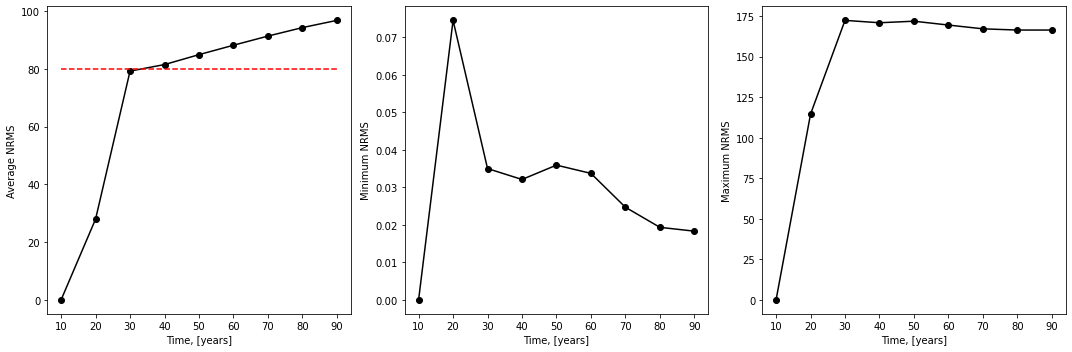

In [17]:
# Plot NRMS histogram
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
res = ax.hist(nrms[0], bins=25)
ax.set_xlabel('NRMS values')
ax.set_ylabel('Counts')

# Plot time changes in NRMS metrics
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for ind, (nm, obs_label) in enumerate(zip(['ave_NRMS', 'min_NRMS', 'max_NRMS'],
                                          ['Average', 'Minimum', 'Maximum'])):
    axs[ind].plot(time_points, metrics[nm], '-ok')
    axs[ind].set_xlabel('Time, [years]')
    axs[ind].set_ylabel(obs_label+' NRMS')
axs[0].plot([time_points[0], time_points[-1]], 2*[threshold], '--r')
fig.tight_layout()

##### Seismic Evaluation Component Outputs
Plot leak_detected flag variable.

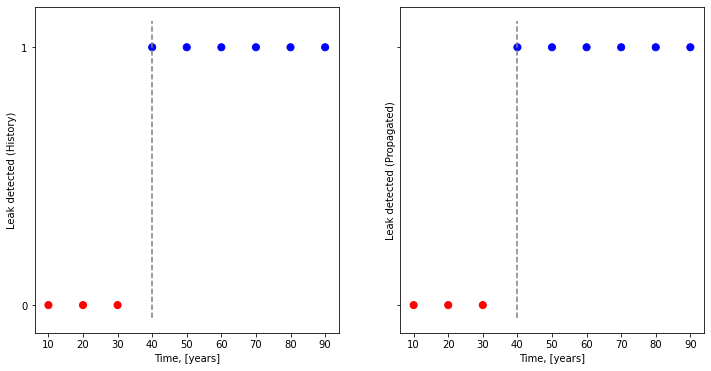

In [18]:
# Plot leak_detected metric
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
for ind, nm in enumerate(['leak_detected_ts', 'leak_detected']):
    colors = np.where(evaluations[nm]==1, 'blue', 'red')
    axs[ind].scatter(time_points, evaluations[nm], s=50, c=colors)
    try:
        mark_time_ind = np.where(evaluations[nm]==1)[0][0]
        axs[ind].plot(2*[time_points[mark_time_ind]], [-0.05, 1.1], '--', color='gray')
    except IndexError:
        pass
    axs[ind].set_xlabel('Time, [years]')
axs[0].set_yticks([0, 1], labels=[0, 1])
axs[0].set_ylabel('Leak detected (History)')
ylbl = axs[1].set_ylabel('Leak detected (Propagated)')